In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

from pathlib import Path
from kloppy.domain.models import Point
from sklearn.model_selection import train_test_split


from soccer_analytics.data.statsbomb import get_metadata, get_events
from soccer_analytics.data_split import split_by_time
from soccer_analytics.preprocessing import match_list_to_df, AngleNormalizer

In [2]:
competitions = get_metadata()

In [16]:
full_competitions = {
    "1. Bundesliga": ["2015/2016"],
    "FA Women's Super League": ["2018/2019", "2019/2020", "2020/2021"],
    "FIFA World Cup": ["2018", "2022"],
    "Indian Super league": ["2021/2022"],
    "La Liga": ["2015/2016"],
    "Ligue 1": ["2015/2016"],
    "Premier League": ["2015/2016"],
    "Serie A": ["2015/2016"],
    "UEFA Euro": ["2020"],
    "UEFA Women's Euro": ["2022"],
    "Women's World Cup": ["2019", "2023"]
}

In [17]:
matches_by_competition = {}
for competition in competitions:
    print(competition.name, len(competition.seasons))
    if competition.name in full_competitions:
        matches_by_competition[competition.name] = []
        for season in competition.seasons:
            print(f"    {season.name}: {len(season.matches)}")
            if season.name in full_competitions[competition.name]:
                matches_by_competition[competition.name].extend(get_events(
                    season, event_types=["shot"]
                ))

1. Bundesliga 1
debug 1. Bundesliga
    2015/2016: 306
Champions League 18
Copa del Rey 3
FA Women's Super League 3
debug FA Women's Super League
    2020/2021: 131
    2019/2020: 87
    2018/2019: 108
FIFA U20 World Cup 1
FIFA World Cup 8
debug FIFA World Cup
    2022: 64
    2018: 64
    1990: 1
    1986: 3
    1974: 6
    1970: 6
    1962: 1
    1958: 2
Indian Super league 1
debug Indian Super league
    2021/2022: 115
La Liga 18
debug La Liga
    2020/2021: 35
    2019/2020: 33
    2018/2019: 34
    2017/2018: 36
    2016/2017: 34
    2015/2016: 380
    2014/2015: 38
    2013/2014: 31
    2012/2013: 32
    2011/2012: 37
    2010/2011: 33
    2009/2010: 35
    2008/2009: 31
    2007/2008: 28
    2006/2007: 26
    2005/2006: 17
    2004/2005: 7
    1973/1974: 1
Liga Profesional 2
Ligue 1 3
debug Ligue 1
    2022/2023: 32
    2021/2022: 26
    2015/2016: 0
Major League Soccer 1
North American League 1
NWSL 1
Premier League 2
debug Premier League
    2015/2016: 380
    2003/2004: 38
Se

In [60]:
all_matches = []
all_train_matches = []
for competition_name, matches in matches_by_competition.items():
    if len(matches) > 0:
        print(competition_name)
        train_test_matches, _ = split_by_time(matches, test_frac=0.2)
        train_matches, test_matches = train_test_split(
            train_test_matches, test_size=0.2, random_state=235
        )
        all_train_matches.extend(train_matches)
        all_matches.extend(matches)

1. Bundesliga
FA Women's Super League
FIFA World Cup
Indian Super league
La Liga
Premier League
Serie A
UEFA Euro
UEFA Women's Euro
Women's World Cup


In [61]:
len(all_matches), len(all_train_matches)

(2213, 1410)

In [20]:
n_points = 192
x = np.linspace(40, 120, n_points)
y = np.linspace(0, 80, n_points)
x_mesh, y_mesh = np.meshgrid(x, y)


In [35]:
def make_player_heatmap(location: Point, x_mesh, y_mesh, sigma=1, cutoff=3):
    rs = np.sqrt((location.x - x_mesh)**2 + (location.y - y_mesh)**2)
    heatmap = np.zeros(x_mesh.shape)
    heatmap += np.exp(-0.5 * (rs/sigma)**2)
    heatmap[rs > cutoff] = 0
    return heatmap

def make_shot_heatmap(shot, x_mesh, y_mesh, sigma=1, cutoff=3):
    rgb = np.ones(x_mesh.shape + (3,), dtype=float) * 255
    shooting_team = shot.ball_owning_team
    shooter = shot.player
    for player, location in shot.freeze_frame.players_coordinates.items():
        heatmap = make_player_heatmap(location, x_mesh, y_mesh, sigma=sigma, cutoff=cutoff) * 255
        if player == shooter:
            rgb[:, :, 0] -= heatmap
            rgb[:, :, 1] -= heatmap
        elif player.team != shooting_team:
            if player.position and player.position.name == "Goalkeeper":
                rgb[:, :, 0] -= heatmap
                rgb[:, :, 2] -= heatmap
            else:
                rgb[:, :, 1] -= heatmap
                rgb[:, :, 2] -= heatmap
    rgb[rgb < 0] = 0
    
    return rgb

In [36]:
notebook_dir = Path(os.getcwd())
data_dir = notebook_dir.parent.parent / "data"
image_dir = data_dir / "shot_images"
image_dir

PosixPath('/Users/rook/repos/mine/soccer_analytics/data/shot_images')

In [63]:
num_shots = 0
for i, match in enumerate(all_matches):
    for shot in match:
        if shot.freeze_frame:
            heatmap = make_shot_heatmap(shot, x_mesh, y_mesh)
            folder = "no_goal" if shot.result.is_success is False else "goal"
            directory = image_dir / folder 
            directory.mkdir(parents=True, exist_ok=True)
            plt.imsave(directory / (shot.record_id + ".jpg"), heatmap.astype(np.uint8))
            num_shots += 1
num_shots

55963

In [40]:
from fastbook import *  #ugh
from fastai.vision.widgets import *

In [64]:
filenames = get_image_files(image_dir)
filenames

(#55963) [Path('/Users/rook/repos/mine/soccer_analytics/data/shot_images/no_goal/550eed57-4c0f-403f-a0e5-70002e58b3ab.jpg'),Path('/Users/rook/repos/mine/soccer_analytics/data/shot_images/no_goal/9a8e0ac0-4da0-43e4-a3ed-b1010b22bebf.jpg'),Path('/Users/rook/repos/mine/soccer_analytics/data/shot_images/no_goal/80975462-2a98-4b17-baba-d7f5691ed85f.jpg'),Path('/Users/rook/repos/mine/soccer_analytics/data/shot_images/no_goal/0aad613a-8ef2-407f-87b1-770579901335.jpg'),Path('/Users/rook/repos/mine/soccer_analytics/data/shot_images/no_goal/02e35e46-8c29-4ace-8afe-f3aa13bb700d.jpg'),Path('/Users/rook/repos/mine/soccer_analytics/data/shot_images/no_goal/51460d98-215a-45f9-992d-850c1a14a042.jpg'),Path('/Users/rook/repos/mine/soccer_analytics/data/shot_images/no_goal/9881518f-0fa5-4fcd-b364-d3edb80c4571.jpg'),Path('/Users/rook/repos/mine/soccer_analytics/data/shot_images/no_goal/9c017446-39a4-40d2-b0d4-914a144e885d.jpg'),Path('/Users/rook/repos/mine/soccer_analytics/data/shot_images/no_goal/cef7fce

In [65]:
goal_data = DataBlock(
    blocks=[ImageBlock, CategoryBlock],
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label
).dataloaders(image_dir)

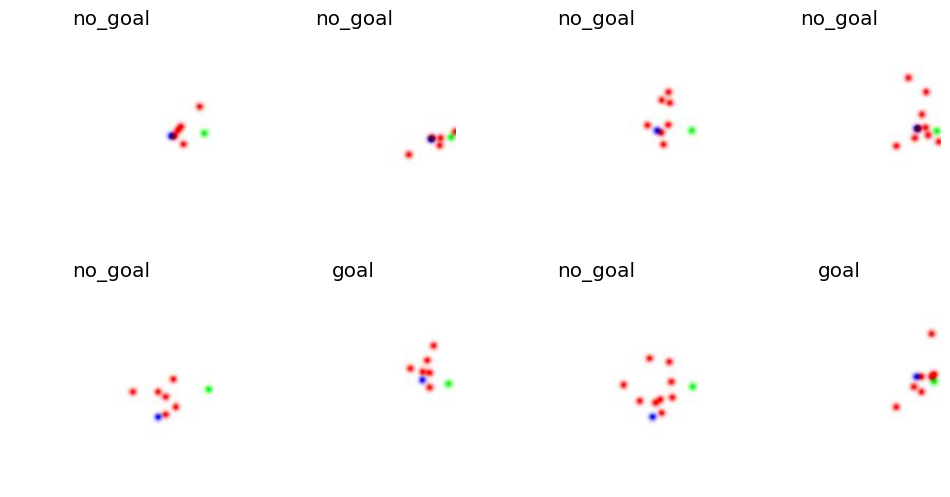

In [66]:
goal_data.valid.show_batch(max_n=8, nrows=2)

In [73]:
#model = vision_learner(goal_data, resnet18, metrics=RocAucBinary())
model = vision_learner(goal_data, resnet18, metrics=error_rate)
model.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.338731,0.311169,0.097927,02:14


epoch,train_loss,valid_loss,error_rate,time
0,0.298741,0.282163,0.095515,03:03
1,0.276296,0.270371,0.095157,03:03
2,0.245750,0.274261,0.096944,03:03


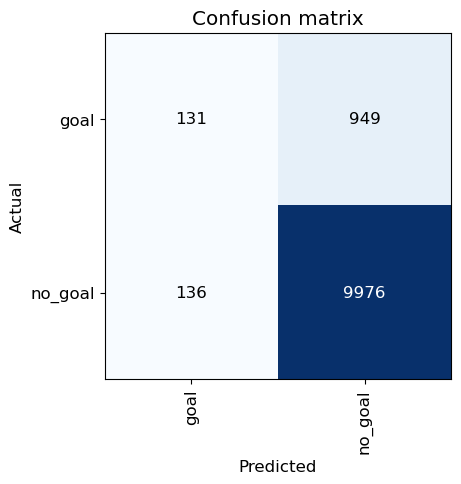

In [74]:
interp = ClassificationInterpretation.from_learner(model)
interp.plot_confusion_matrix()

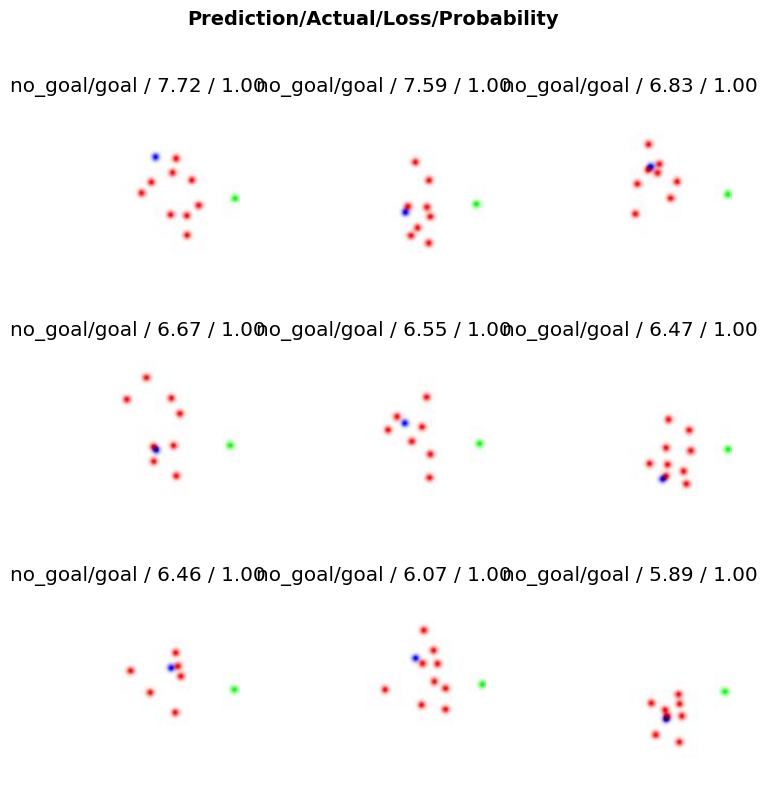

In [77]:
interp.plot_top_losses(9, nrows=3)